# Shallow water models of coastal upwelling

This notebook summarizes several attempts to model coastal upwelling in the Strait of Georgia using the shallow water equations. These modelling attempts are an effort to explain the dynamics of enhanced upwelling around capes that we observe in the SalishSeaCast model (see [**Motivation**](#Motivation)). The following cases are explored:

   1. [**Linear time dependence**](#Linear-time-dependence)
       * [Surface height sink near coast](#Surface-height-sink-near-coast)
       * [Linear bottom friction](#Linear-bottom-friction)
       * [Longshore windstress](#Longshore-windstress)
   2. [**Steady state**](#Steady-state)
       * [Linear bottom friction, non-zero depth gradient](#Linear-bottom-friction,-non-zero-depth-gradient)
       * [Longshore bottom friction, cross-shelf bottom slope](#Longshore-bottom-friction,-cross-shelf-bottom-slope)

***

### Preamble

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import os
import warnings
from cmocean import cm
from salishsea_tools import viz_tools, grid_tools

# Global constants
f = 1e-4      # [s-1]
g = 9.81      # [m s-2]

%matplotlib inline
plt.rcParams['font.size'] = 14
warnings.simplefilter('ignore')

***

### Local functions

In [3]:
def load_results(t, rundir, prefix, maskfile, xrange=[None], yrange=[None]):
    """Load SalishSeaCast velocities, tracers, and grid parameters
    """

    # Load netCDF files
    T = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_T.nc'))
    U = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_U.nc'))
    V = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_V.nc'))
    mask = xr.open_dataset(maskfile)
    
    # Define slices
    xslice = slice(*xrange)
    yslice = slice(*yrange)
    
    # Define parameters
    params = {
        'x': mask.x[xslice].values,
        'y': mask.y[yslice].values,
        'u': U.vozocrtx[t, :, yslice, xslice].values,
        'v': V.vomecrty[t, :, yslice, xslice].values,
        'eta': T.sossheig[t, yslice, xslice].values,
        'tmask': mask.tmask[0, :, yslice, xslice].values,
        'gdept_0': mask.gdept_0[0, :, yslice, xslice].values,
        'e1t': mask.e1t[0, yslice, xslice].values,
        'e2t': mask.e2t[0, yslice, xslice].values,
        'e3t_0': mask.e3t_0[0, :, yslice, xslice].values,
    }
    
    # Obtain the time dependent grid parameters
    VVL = grid_tools.calculate_time_dependent_grid(
        params['e3t_0'], params['tmask'], params['eta'][np.newaxis, ...],
        {'e3t_t': params['e3t_0'][np.newaxis, ...], 'gdept_t': params['gdept_0'][np.newaxis, ...]},
    )
    
    # Calculate rho
    rho = gsw.rho(T.vosaline[t, :, yslice, xslice], T.votemper[t, :, yslice, xslice], VVL['gdept_t'][0, ...])
    
    # Finalize output dict
    params.update({
        'rho': rho,
        'e3t_t': VVL['e3t_t'][0, ...],
        'gdept_t': VVL['gdept_t'][0, ...],
    })
    
    return params

In [4]:
def calc_geostrophic_velocities(z, params, corr=False):
    """Calculate pressure gradients and geostrophic velocities at idepth
    """
    
    # Geostrophic parameters dict
    GEO = {}

    # Calculate z surface displacement xi
    stretching = params['e3t_t'][:z, ...].sum(axis=0) - params['e3t_0'][:z, ...].sum(axis=0)
    xi = params['eta'] - stretching

    # Define rho at z surface
    rho_bot = params['rho'][z, ...]
    rho_bot[xi < 0] = params['rho'][z - 1, ...][xi < 0]

    # Calculate pressure
    GEO['pressure'] = g * ((params['rho'][:z, ...] * params['e3t_t'][:z, ...]).sum(axis=0) + rho_bot * xi)
    
    # Extract and unstagger the model velocity fields
    GEO['u'] = params['u'][z, ...]
    GEO['v'] = params['v'][z, ...]
    GEO['u'][1:, 1:], GEO['v'][1:, 1:] = viz_tools.unstagger(GEO['u'], GEO['v'])

    # Calculate the pressure gradient
    dpdy, dpdx = np.gradient(GEO['pressure'], axis=(0, 1))

    # Calculate the geostrophic velocities
    GEO['u_g'] = -1 / (f * params['rho'][z, ...]) * dpdy / params['e2t']
    GEO['v_g'] = 1 / (f * params['rho'][z, ...]) * dpdx / params['e1t']

    # Calculate ageostrophic velocities
    GEO['u_a'] = GEO['u'] - GEO['u_g']
    GEO['v_a'] = GEO['v'] - GEO['v_g']

    return GEO

In [5]:
def plot_results(params, GEO):
    """Plot SalishSeaCast results
    """
    
    # Make figure panels
    fig, axs = plt.subplots(1, 4, figsize=(17, 8))
    caxs = [fig.add_axes([xbar, 0.05, 0.17, 0.015]) for xbar in [0.125, 0.325]]

    # Plot results
    cs, qs = [0, 0], [0, 0]
    uindex = (abs(GEO['u_g']) > 0.1) | (abs(GEO['v_g']) > 0.1)
    u_g = np.ma.masked_where(uindex, GEO['u_g'])
    v_g = np.ma.masked_where(uindex, GEO['v_g'])
    cs[0] = axs[0].contourf(params['x'], params['y'], params['eta'], levels=np.arange(0, 0.12, 0.005), cmap=cm.deep, extend='both')
    cs[1] = axs[1].contourf(params['x'], params['y'], GEO['pressure']*1e-4, levels=np.arange(39.083, 39.13, 0.001), cmap=cm.dense, extend='both')
    qs[0] = axs[2].quiver(params['x'][::5], params['y'][::5], GEO['u'][::5, ::5], GEO['v'][::5, ::5], width=0.004, scale=1.8)
    qs[1] = axs[3].quiver(params['x'][::5], params['y'][::5], u_g[::5, ::5], v_g[::5, ::5], width=0.004, scale=1.8)

    # Format panels
    for ax, title in zip(axs, ['$\eta$', '$P_{40m}$', 'u$_{40m}$', 'u$_{40m}$ (geostrophic)']):
        ax.contourf(params['x'], params['y'], params['tmask'][0, ...], levels=[-0.01, 0.01], colors='burlywood')
        ax.contour(params['x'], params['y'], params['tmask'][0, ...], levels=[-0.01, 0.01], colors='k')
        ax.set_title(title)
        ax.set_xlabel('Grid X')
        if title is '$\eta$':
            ax.set_ylabel('Grid Y')
        else:
            ax.yaxis.set_ticklabels([])
        viz_tools.set_aspect(ax)

    # Add colorbars
    for cax, c, q, ticks, label in zip(caxs, cs, qs, [[0, 0.05, 0.1], [39.09, 39.11, 39.13]], ['[m]', '[dbar]']):
        plt.colorbar(c, cax=cax, orientation='horizontal', ticks=ticks, label=label)
        qkey = ax.quiverkey(q, 0.8, 0.75, 0.1, '0.1 m/s')

    plt.show()
    
    return

***

## Motivation

We will examine the SalishSeaCast results for 28 April, 2015 using the lake domain with closed boundaries (no tides).

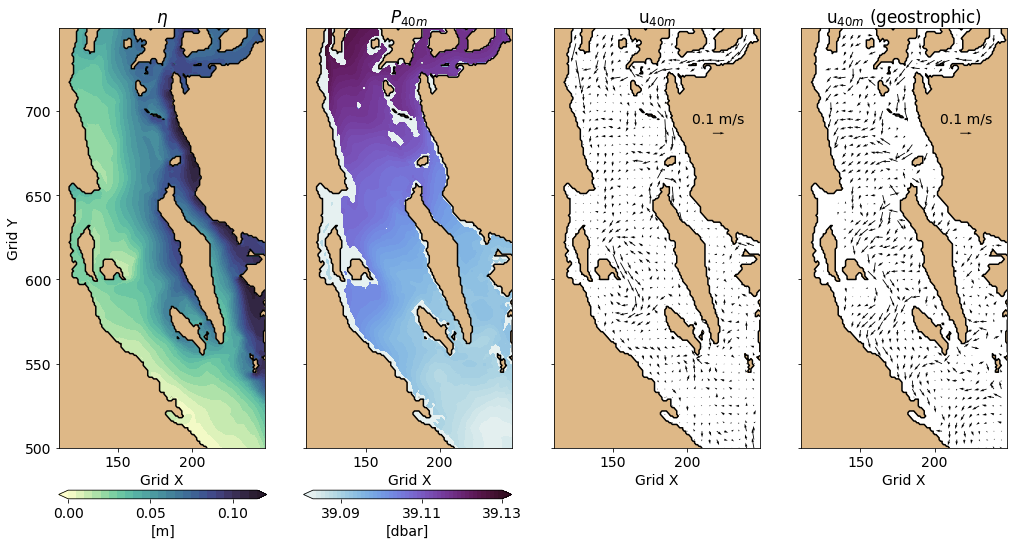

In [6]:
# Load and plot SalishSeaCast results for Baynes Sound upwelling event
rundir = '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15lake'
prefix = 'SalishSea_1h_20150424_20150429'
maskfile = '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc'
z = 23
t = 70
lims = [110, 250, 500, 750]
params = load_results(t, rundir, prefix, maskfile, xrange=lims[:2], yrange=lims[2:])
GEO = calc_geostrophic_velocities(z, params)
plot_results(params, GEO)

**We observe the following during this event:**
   1. Surface height moves laterally offshore ($\eta$ panel)
   2. Pressure at 40 m sets up in the longshore direction ($P_{40\text{m}}$ panel)
   3. Total velocity field at 40 m flows dominantly to the south ($\mathbf{u}_{40\text{m}}$ panel)
   4. Geostrophic velocity field at 40 m is onshore, consistent with the 40 m pressure field ($\mathbf{u}_{40\text{m}}$ (geostrophic) panel)
   5. Enhanced upwelling results on the seaward edge of Denman and Hornby Islands (not shown)
   
**We seek a simplified, conceptual model that**
   1. Reproduces the first-order structure of the SalishSeaCast results
   2. Can be used to explain the mechanics of the enhanced upwelling near Denman and Hornby Islands
   
**Plan**

We will experiment with various terms in the barotropic shallow water equations. If we find a promising model, we will consider baroclinity either by using a 1.5 or 2 layer model or by considering mass conservation.

***

## Shallow water model

The family of models in this notebook are based on the linearized, time-dependent shallow water equations

\begin{align}
\frac{\partial\mathbf{u}}{\partial t} + f\mathbf{k}\times\mathbf{u} & = -g\nabla\eta \tag{1a} \\
\frac{\partial\eta}{\partial t} + \nabla\cdot h\mathbf{u} & = 0 \tag{1b}
\end{align}

***

## Linear time dependence

In order to avoid a strictly steady-state model, we seek solutions ($\nabla h = 0$) to (1) that are both linear and constant in time, e.g.,

\begin{align}
\mathbf{u} & = \mathbf{u}_1ft + \mathbf{u}_0 \tag{2a} \\
\eta & = \eta_1ft + \eta_0 \tag{2b}
\end{align}

The equations proportional to $t$ are thus

\begin{align}
f\mathbf{k}\times\mathbf{u}_1 & = -g\nabla\eta_1 \tag{3a} \\
\nabla\cdot\mathbf{u}_1 & = 0 \tag{3b}
\end{align}

and the steady equations are thus

\begin{align}
f\mathbf{u}_1 + f\mathbf{k}\times\mathbf{u}_0 & = -g\nabla\eta_0 \tag{4a} \\
f\eta_1 + h\nabla\cdot\mathbf{u}_0 & = 0 \tag{4b}
\end{align}

Since the growing velocity $\mathbf{u}_1$ is in geostrophic balance (3a), ageostrophic velocities associated with Ekman transport must be part of the steady velocity $\mathbf{u}_0$. If we let $\mathbf{u}_0 = \mathbf{u}_g + \mathbf{u}_a$ such that

$$f\mathbf{k}\times\mathbf{u}_g = -g\nabla\eta_0 \tag{5}$$

then the steady ageostrophic velocity $\mathbf{u}_a$ (Ekman transport) feeds the growing geostrophic velocity $\mathbf{u}_1$

$$\mathbf{u}_1 + \mathbf{k}\times\mathbf{u}_a = 0 \tag{6}$$

or the growing surface height gradient (substituting 3a)

$$\mathbf{u}_a = -\frac{g}{f}\nabla\eta_1 \tag{7}$$

In order to use this model, we need to force the surface height field $\eta$. Options are as follows.

***

### Surface height sink near coast

(Susan's canyon model, Allen 1996)

Adding a coastal surface sink $q$ to (1b) such that

$$\frac{\partial\eta}{\partial t} + h\nabla\cdot\mathbf{u} = -q \tag{8}$$

results in the following vorticity balance (curl of 1a but considering 8)

$$\frac{\partial}{\partial t}\left(h\nabla\times\mathbf{u} - f\eta\right) = fq \tag{9}$$

Substituting (2) into (9) along with the momentum and continuity balances gives the following equations for the time-dependent ($\eta_1$) and constant ($\eta_0$) surface heights

\begin{align}
R^2\nabla^2\eta_1 - \eta_1 & = \frac{q}{f} \tag{10a} \\
R^2\nabla^2\eta_0 - \eta_0 & = 0 \tag{10b} \\
\end{align}

where $R = \sqrt{gh}/f$ is the barotropic Rossby radius.

Equation (10a) is solved as the sum of homogeneous and particular solutions

$$\eta_1(x, y) = \eta_{1_H}(x, y) + \eta_{1_P}(x) \tag{11}$$

Since $q$ is confined to a region $x < E$, $\eta_P$ (given in Allen 1996) is defined piecewise

$$\eta_{1_P}(x) =
\begin{cases}
\frac{q_0}{f}\left[\left(\frac{\alpha\sinh\left(\frac{S - E}{R}\right) + \cosh\left(\frac{S - E}{R}\right)}{\alpha\sinh\left(\frac{S}{R}\right) + \cosh\left(\frac{S}{R}\right)}\right)\cosh\left(\frac{x}{R}\right) - 1\right],  & \quad x < E \\
-\frac{q_0}{f}\left(\frac{\sinh\left(\frac{E}{R}\right)}{\alpha\sinh\left(\frac{S}{R}\right) + \cosh\left(\frac{S}{R}\right)}\right)\left[\alpha\cosh\left(\frac{S - x}{R}\right) + \sinh\left(\frac{S - x}{R}\right)\right],  & \quad E < x < S
\end{cases} \tag{12}
$$

where $\alpha$ is the depth ratio over across the shelfbreak. $\eta_{1_H}$ is solved in the absence of $q$ such that $\eta_1=0$ at the coast and shelfbreak and decays as $y \to -\infty$. The solution is given in Allen (1996).

$$\eta_{1_H} = \sum_{n=1}^\infty c_n\exp\left\{y\left[\frac{1}{R^2} + \left(\frac{n\pi}{S}\right)^2\right]^{1/2}\right\}\sin\left(\frac{n\pi x}{S}\right) \tag{13}$$

The $c_n$ coefficients determine the streamlines against and around the cape (at $y=0$).

\begin{align}
\eta_{1_H}(x, 0) & = \eta_{1_P}(0) - \eta_{1_P}(x) & \text{for } x = [0, M] \tag{14a}\\
\frac{\partial}{\partial x}\eta_{1_H}(x, 0) & = 0 & \text{for } x = [M, S] \tag{14b}
\end{align}

In [7]:
# Parameters
tau = 1e-4    # Kinematic windstress         [m2 s-2]
H_s = 50      # Depth over shelf             [m]
H_d = 5e2     # Depth beyond shelfbreak      [m]
S = 1e4       # Shelf width                  [m]
E = 1e3       # Upwelling lengthscale        [m]
M = S/2       # Cape length                  [m]
N = 1000      # Fourier series limit

# Terms
R = np.sqrt(g * H_s) / f     # Rossby radius [m]
alpha = np.sqrt(H_s / H_d)   # Depth ratio
q_0 = tau / (E * f)  # Ekman velocity [m/s]

In [8]:
def calc_eta_P(x, q_0, f, R, S, E):
    """Calculate the particular solution eta_P(x)
    """

    top = alpha * np.sinh((S - E) / R) + np.cosh((S - E) / R)
    bot = alpha * np.sinh(S / R) + np.cosh(S / R)
    eta_P = -q_0 / f * np.sinh(E / R) / bot * (alpha * np.cosh((S - x) / R) + np.sinh((S - x) / R))
    eta_P[x <= E] = q_0 / f * (top / bot * np.cosh(x[x <= E] / R) - 1)
    
    return eta_P

In [9]:
# Calculate C coefficients according to y=0 boundary conditions

# Coordinates
x_ni = np.arange(1, N + 1) / N * S
ni = np.arange(1, N + 1, dtype=int)
n, x_n = np.meshgrid(ni, x_ni)
xindex = x_ni <= M

# Allocate matrix A and RHS
A = np.zeros([N, N])
RHS = np.zeros([N, 1])

# Populate A matrix
A[xindex, :] = np.sin(n[xindex, :] * np.pi * x_n[xindex, :] / S)
A[~xindex, :] = np.sqrt(1 / R**2 + (n[~xindex, :] * np.pi / S)**2) * np.sin(n[~xindex, :] * np.pi * x_n[~xindex, :] / S)

# Populate RHS
RHS[xindex, 0] = calc_eta_P(np.array([0]), q_0, f, R, S, E) - calc_eta_P(x_ni[xindex], q_0, f, R, S, E)

# Solve for C coefficients
C = np.linalg.solve(A, RHS)

In [10]:
# Calculate eta_H
xi = np.arange(0, S, S*1e-2)
yi = np.arange(-S, 0, S*1e-2)
x, y = np.meshgrid(xi, yi)
eta_H = np.zeros(x.shape)
for n, C_n in zip(range(1, N + 1), C):
    eta_H = eta_H + C_n * np.exp(y * np.sqrt(1 / R**2 + (n * np.pi / S)**2)) * np.sin(n * np.pi * x / S)

# Calculate eta
eta_P = calc_eta_P(x, q_0, f, R, S, E)
eta = eta_H + eta_P

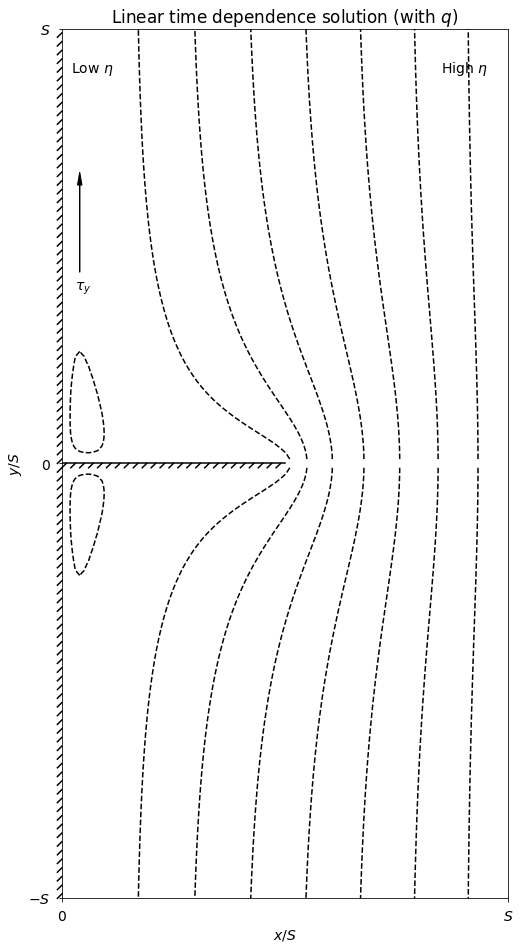

In [11]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
ax.contour(x/S, y/S, eta, colors='k')
ax.contour(x/S, -y/S, eta, colors='k')
ax.plot([0, M/S], [0, 0], 'k-')
for tick in np.arange(-1, 1, 0.02):
    ax.plot([-0.01, 0], [tick, tick+0.01], 'k-', clip_on=False)
for tick in np.arange(0, M/S, 0.02):
    ax.plot([tick, tick+0.01], [-0.01, 0], 'k-', clip_on=False)
ax.set_xlabel('$x/S$')
ax.set_ylabel('$y/S$')
ax.xaxis.set_ticks([0, 1])
ax.yaxis.set_ticks([-1, 0, 1])
ax.xaxis.set_ticklabels([0, '$S$'])
ax.yaxis.set_ticklabels(['$-S$', 0, '$S$'])
ax.tick_params(direction='out', pad=8)
ax.set_xlim([0, 1])
ax.set_ylim([-1, 1])
ax.text(0.02, 0.95, 'Low $\eta$', transform=ax.transAxes)
ax.text(0.85, 0.95, 'High $\eta$', transform=ax.transAxes)
ax.text(0.03, 0.7, '$\\tau_y$', transform=ax.transAxes)
ax.arrow(0.04, 0.72, 0, 0.1, transform=ax.transAxes, head_width=0.01, facecolor='k')
ax.set_title('Linear time dependence solution (with $q$)')

plt.show()

**Problem**

Since the coastal boundaries in this model are in geostrophic balance (according to 3a and 4a), the streamlines conform to all coastal features. However, numerical results show a longshore pressure setup that drives geostrophic flow onshore.

A better model would have a mechanism to supply the coastal upwelling with geostrophic onshore flow rather than just ageostrophic flow. Thus, we seek a model that balances the longshore pressure gradient at the coast.

***

### Linear bottom friction

Bottom friction is a logical forcing to balance the surface height at the coast. We can add linear friction to (1a) such that

$$\frac{\partial\mathbf{u}}{\partial t} + f\mathbf{k}\times\mathbf{u} = -g\nabla\eta - \frac{\mu}{h}\mathbf{u} \tag{15}$$

The potential vorticity balance is then

$$\frac{\partial}{\partial t}\left(h\nabla\times\mathbf{u} - f\eta\right) = -\mu\nabla\times\mathbf{u} + fq \tag{16}$$

**Problem**

The part of (16) proportional to $t$ is

$$\nabla\times\mathbf{u}_1 = 0 \tag{17}$$

which implies, considering the part of (15) proportional to $t$, that

$$\nabla^2\eta_1 = 0 \tag{18}$$

So linear bottom friction with linear time dependence gives only trivial solutions for the growing $\mathbf{u}_1$ and $\eta_1$ fields. We need another way to balance the surface height setup at the coast.

***

### Longshore windstress

Longshore windstress at the coast provides another way to balance the longshore surface height gradient. We can add longshore windstress $\tau_y$ to (1a) such that

$$\frac{\partial\mathbf{u}}{\partial t} + f\mathbf{k}\times\mathbf{u} = -g\nabla\eta + \tau_y{\hat{\jmath}} \tag{19}$$

If the windstress curl is zero, potential vorticity is conserved.

$$\frac{\partial}{\partial t}\left(h\nabla\times\mathbf{u} - f\eta\right) = 0 \tag{20}$$

Substituting (2) into (19) and (20) gives similar equations to (10) except the growing solution is now unforced (homogeneous).

$$R^2\nabla^2\eta_1 - \eta_1 = 0 \tag{21} $$

Windstress forcing in this case comes from the coastal boundary condition

\begin{align}
\frac{\partial\eta_1}{\partial y} & = 0 \tag{22a} \\
\frac{\partial\eta_1}{\partial x} & = -\frac{\partial\eta_0}{\partial y} + \frac{\tau_y}{g} \tag{22b}
\end{align}

The growing surface height field is geostrophic at the coast, and is not fully constrained so will yield a trivial solution. The steady field however is balanced by the longshore windstress $\tau_y$. Equation (7) thus becomes

$$\mathbf{u}_a = \hat{\mathbf{k}}\times\tau_y \tag{23}$$

Thus the ageostrophic velocity is a constant cross-shore velocity perpendicular to the windstress. This solution could still be interesting though since part of the cross-shore flow is geostrophic.

***

## Steady state

Neglecting time dependence entirely, the linearized, steady state shallow water equations are

\begin{align}
f\mathbf{k}\times\mathbf{u} & = -g\nabla\eta \tag{24a} \\
0 & = \nabla\cdot h\mathbf{u} \tag{24b}
\end{align}

The momentum balance (24a) is entirely geostrophic so the curl of (24a) results in only trivial solutions

$$\nabla\cdot\mathbf{u} = 0 \tag{25}$$

We need additional forces in order to balance the divergence.

***

### Linear bottom friction, non-zero depth gradient

Take the linearized, steady state shallow water equations with linear bottom friction.

\begin{align}
f\mathbf{k}\times\mathbf{u} & = -g\nabla\eta - \frac{\mu}{h}\mathbf{u} \tag{26a} \\
0 & = \nabla\cdot h\mathbf{u} \tag{26b}
\end{align}

Obtain the vorticity balance by taking the curl of (26a) and substituting (26b)

$$\frac{1}{g}\left(f^2 + \frac{\mu^2}{h^2}\right)\mathbf{u}\cdot\nabla h = \mu\nabla^2\eta \tag{27}$$

Non-trivial solutions exist only for a non-zero bottom gradient. Therefore we let $\nabla h \neq 0$. Solve (26a) for $u$ and $v$

\begin{align}
\left(f^2 + \frac{\mu^2}{h^2}\right)\frac{u}{g} & = -f\frac{\partial\eta}{\partial y} - \frac{\mu}{h}\frac{\partial\eta}{\partial x} \tag{28a}\\
\left(f^2 + \frac{\mu^2}{h^2}\right)\frac{v}{g} & = f\frac{\partial\eta}{\partial x} - \frac{\mu}{h}\frac{\partial\eta}{\partial y} \tag{28b}
\end{align}

and substitute (28) into (27) to isolate $\eta$

$$ -\left(f\frac{\partial\eta}{\partial y} + \frac{\mu}{h}\frac{\partial\eta}{\partial x}\right)\frac{\partial h}{\partial x} + \left(f\frac{\partial\eta}{\partial x} - \frac{\mu}{h}\frac{\partial\eta}{\partial y}\right)\frac{\partial h}{\partial y} = \mu\nabla^2\eta \tag{29}$$

For simplicity, we can only consider a linear bottom slope in the cross-shore direction. Let $\frac{\partial h}{\partial y} = 0$, $\frac{\partial h}{\partial x} = s$

$$ \frac{1}{s}\nabla^2\eta + \frac{1}{h}\frac{\partial\eta}{\partial x} + \frac{f}{\mu}\frac{\partial\eta}{\partial y} = 0 \tag{30}$$

Equation (30) is a linear PDE and potentially solveable. But we can make further simplifications to (26).

***

### Longshore bottom friction, cross-shelf bottom slope

Take the linearized, steady state shallow water equations with linear friction and longshore windstress. Assume cross-shore geostrophic balance.

\begin{align}
f\mathbf{k}\times\mathbf{u} & = -g\nabla\eta + \frac{1}{h}\left(\tau_y - \mu v\right)\hat{\jmath} \tag{31a} \\
0 & = \nabla\cdot h\mathbf{u} \tag{31b}
\end{align}

The geostrophic velocity balances the surface height gradient while the ageostrophic velocity $u_a$ (cross-shelf only) balances windstress and friction through Coriolis and geostrophy.

$$u_a = \frac{1}{fh}\left(\tau_y - \frac{\mu g}{f}\frac{\partial\eta}{\partial x}\right) \tag{32}$$

Taking the curl of (31a) and considering (31b), the vorticity balance yields

$$\frac{f^2}{\mu g}u = \frac{1}{h_x}\frac{\partial^2\eta}{\partial x^2} - \frac{1}{h}\frac{\partial\eta}{\partial x} \tag{33}$$

Substituting (31a) gives the heat equation analog

$$\frac{\partial^2\eta}{\partial x^2} - \frac{1}{\kappa}\frac{\partial\eta}{\partial y} = 0, \hspace{0.5cm} \frac{1}{\kappa} = -\frac{f}{\mu}\frac{\partial h}{\partial x}\tag{34}$$

Equation (34) is the Arrested Topography Wave (ATW) of Csanady (1978 *JPO*). As a heat diffusion equation, the ATW model simulates a propagating shelf wave arrested by bottom friction ($y$-term $\to 0$ as $\mu\to\infty$). As such, only solutions diffusing in the direction of propagating shelf waves make physical sense.

At the coastal boundary, the longshore surface height setup is balanced by the longshore windstress, which is related to the cross-shore surface height gradient through bottom friction and geostrophy. The longshore surface height gradient vanishes as $h\to0$ at the coast.

$$\frac{\partial\eta}{\partial x}(0, y) = \frac{f}{\mu}\left(\frac{\tau_y}{g} - h\frac{\partial\eta}{\partial y}\right) = q_0 \tag{35}$$

If we orient our solution to $x\to-\infty$ offshore such that $\frac{\partial h}{\partial x} = -s$, then equation (34) is solvable. Equation (35) is analogous to a constant heat flux boundary condition. The solution is given by Carslaw and Jaeger 1959 (p. 112)

$$\eta(x, y) = \frac{\kappa q_0y}{L} + q_0L\left\{\frac{3(x + L)^2 - L^2}{6L^2} - \frac{2}{\pi^2}\sum_{n=1}^\infty\frac{(-1)^n}{n^2}\exp\left(\frac{-\kappa n^2\pi^2y}{L^2}\right)\cos\left(\frac{n\pi(x + L)}{L}\right)\right\} \tag{36}$$

which, as $y\to\infty$, reduces to

$$\eta(x, y) = \frac{\kappa q_0y}{L} + q_0L\frac{3(x + L)^2 - L^2}{6L^2} \tag{37}$$

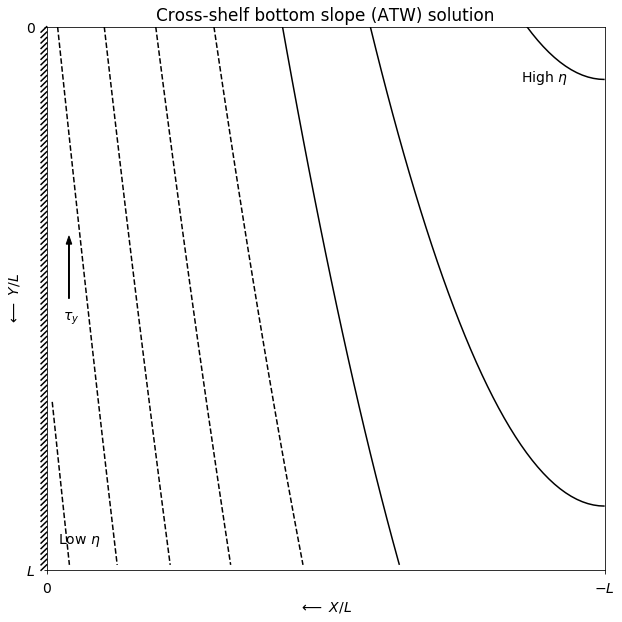

In [12]:
# Barotropic ATW solution forced by windstress at coast

# Constants and terms
L = 1e3        # [m]
tau_y = -1e-4  # [m2 s-2]
mu = 1e-2      # [s-1]
s = 1          # [dimensionless]
dL = L * 1e-2
kappa = mu / (f * s)
q_0 = tau_y * f / (mu * g)

# Coordinates
xi = np.arange(-L, 0, dL)
yi = np.arange(0, L, dL)
x, y = np.meshgrid(xi, yi)

# Solution
eta = kappa * q_0 * y / L + q_0 * L * (3 * (x + L)**2 - L**2) / (6 * L**2)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.contour(xi/L, yi/L, eta, colors='k')
for tick in np.arange(0, 1, 0.01):
    ax.plot([0, 0.01], [tick, tick+0.01], 'k-', clip_on=False)
ax.set_xlabel('$\longleftarrow$ $X/L$')
ax.set_ylabel('$\longleftarrow$ $Y/L$')
ax.xaxis.set_ticks([-1, 0])
ax.yaxis.set_ticks([0, 1])
ax.xaxis.set_ticklabels(['$-L$', 0])
ax.yaxis.set_ticklabels([0, '$L$'])
ax.tick_params(direction='out', pad=8)
ax.set_xlim([0, -1])
ax.set_ylim([1, 0])
ax.text(0.02, 0.05, 'Low $\eta$', transform=ax.transAxes)
ax.text(0.85, 0.9, 'High $\eta$', transform=ax.transAxes)
ax.text(0.03, 0.46, '$\\tau_y$', transform=ax.transAxes)
ax.arrow(0.04, 0.5, 0, 0.1, transform=ax.transAxes, head_width=0.01, facecolor='k')
ax.set_title('Cross-shelf bottom slope (ATW) solution')

plt.show()

The ATW model rotates the cross-shore surface height setup anticlockwise, similar to what we see in the SalishSeaCast pressure field.

**Problem**

The force balance normal to a coastline is geostrophic. This orientation changes near a cape, but since the $x$ and $y$ directions are inherent to the model, it's not clear how to accomodate the new orientation near the cape.

***